A notebook to extract the data along the Seal Island transect.

In [1]:
import geopy.distance
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

%matplotlib inline

In [2]:
stations = pd.read_table('sealisland.txt', delimiter=' ')
stations

,STATION,LAT,LON
0,SI-01,53.233,-55.650
1,SI-02,53.333,-55.500
2,SI-03,53.410,-55.357
3,SI-04,53.533,-55.145
4,SI-05,53.617,-55.000
5,SI-06,53.757,-54.777
6,SI-07,53.917,-54.500
7,SI-08,54.082,-54.217
8,SI-09,54.200,-54.000
9,SI-10,54.355,-53.733


In [3]:
d = xr.open_dataset('global-analysis-forecast-phy-001-024_1610112405187.nc')
d

<xarray.Dataset>
Dimensions:    (depth: 50, latitude: 37, longitude: 49, time: 1)
Coordinates:
  * latitude   (latitude) float32 53.0 53.083332 53.166668 ... 55.916668 56.0
  * depth      (depth) float32 0.494025 1.541375 2.645669 ... 5274.784 5727.917
  * time       (time) datetime64[ns] 2020-07-25T12:00:00
  * longitude  (longitude) float32 -56.0 -55.916668 ... -52.083332 -52.0
Data variables:
    mlotst     (time, latitude, longitude) float32 ...
    siconc     (time, latitude, longitude) float32 ...
    thetao     (time, depth, latitude, longitude) float32 ...
    usi        (time, latitude, longitude) float32 ...
    sithick    (time, latitude, longitude) float32 ...
    bottomT    (time, latitude, longitude) float32 ...
    vsi        (time, latitude, longitude) float32 ...
    vo         (time, depth, latitude, longitude) float32 ...
    uo         (time, depth, latitude, longitude) float32 ...
    so         (time, depth, latitude, longitude) float32 ...
    zos        (time, l

In [4]:
drop=['mlotst', 'siconc', 'usi','bottomT', 'vsi', 'zos', 'sithick']

In [5]:
dnew = pd.DataFrame()
numrows=stations.shape[0]
numdepths=d.depth.values.shape[0]
temp=np.empty((numdepths, numrows))
sal = np.empty((numdepths, numrows))
for i in range(stations.shape[0]):
    lat=stations.iloc[i]['LAT']
    lon=stations.iloc[i]['LON']
    sid=stations.iloc[i]['STATION']
    dstation = d.interp(latitude=lat, longitude=lon)
    dstation = dstation.drop(drop)
    df=dstation.to_dataframe()
    df['station'] = sid
    df = df.reset_index()
    dnew = pd.concat([dnew,df])
    temp[:, i] = np.squeeze(dstation.thetao.values)
    sal[:, i] = np.squeeze(dstation.so.values)

In [6]:
rename={var: '{} [{}]'.format(d[var].attrs['long_name'], d[var].attrs['units'])
        for var in dnew.columns if var not in ['station', 'time']}
rename['station'] = 'STATION'
rename['time'] = 'TIME'
rename['longitude'] = 'LON'
rename['latitude'] = 'LAT'

In [7]:
dnew = dnew.rename(columns=rename)
dnew = dnew.reset_index(drop=True)
dnew

,Depth [m],TIME,Temperature [degrees_C],Northward velocity [m s-1],Eastward velocity [m s-1],Salinity [1e-3],LAT,LON,STATION
0,0.494025,2020-07-25 12:00:00,9.331520,-0.349346,0.082295,29.615211,53.233,-55.65,SI-01
1,1.541375,2020-07-25 12:00:00,9.151456,-0.359278,0.082098,29.632414,53.233,-55.65,SI-01
2,2.645669,2020-07-25 12:00:00,8.324164,-0.383035,0.073408,29.704880,53.233,-55.65,SI-01
3,3.819495,2020-07-25 12:00:00,7.310033,-0.401451,0.055687,29.808921,53.233,-55.65,SI-01
4,5.078224,2020-07-25 12:00:00,6.444636,-0.408145,0.035361,29.916508,53.233,-55.65,SI-01
...,...,...,...,...,...,...,...,...,...
695,3992.483887,2020-07-25 12:00:00,NaN,NaN,NaN,NaN,55.067,-52.50,SI-14
696,4405.224121,2020-07-25 12:00:00,NaN,NaN,NaN,NaN,55.067,-52.50,SI-14
697,4833.291016,2020-07-25 12:00:00,NaN,NaN,NaN,NaN,55.067,-52.50,SI-14
698,5274.784180,2020-07-25 12:00:00,NaN,NaN,NaN,NaN,55.067,-52.50,SI-14


In [8]:
dnew.to_csv('SealIsland_2020_global-analysis-forecast-phy-001-024.csv', index=False, na_rep='nan')

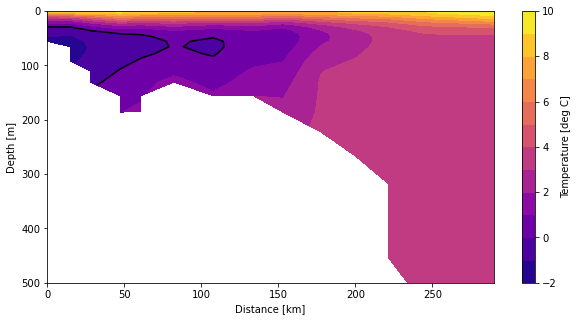

In [9]:
fig, ax= plt.subplots(1,1, figsize=(10,5))
distance = [geopy.distance.distance((stations.iloc[0]['LAT'], stations.iloc[0]['LON']),
                                    (stations.iloc[i]['LAT'], stations.iloc[i]['LON'])).km for i in range(numrows)]
depths, dist = np.meshgrid(d.depth.values, distance)
mesh=ax.contourf(dist, depths,temp.T,cmap='plasma',levels=np.arange(-2, 11,1))
ax.contour(dist, depths,temp.T,[0],colors='k')
ax.set_ylim([500,0])
cbar=plt.colorbar(mesh)
ax.set_ylabel('Depth [m]')
ax.set_xlabel('Distance [km]')
cbar.set_label('Temperature [deg C]')

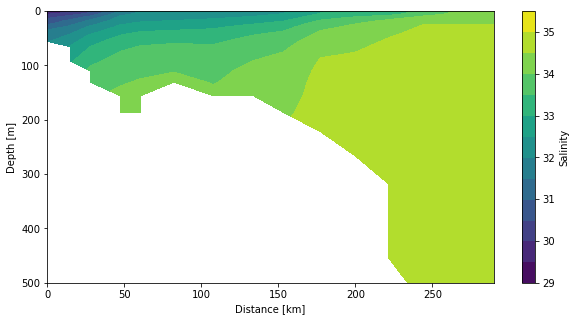

In [10]:
fig, ax= plt.subplots(1,1, figsize=(10,5))
distance = [geopy.distance.distance((stations.iloc[0]['LAT'], stations.iloc[0]['LON']),
                                    (stations.iloc[i]['LAT'], stations.iloc[i]['LON'])).km for i in range(numrows)]
depths, dist = np.meshgrid(d.depth.values, distance)
mesh=ax.contourf(dist, depths,sal.T,cmap='viridis',levels=np.arange(29, 36,0.5))
ax.set_ylim([500,0])
cbar=plt.colorbar(mesh)
ax.set_ylabel('Depth [m]')
ax.set_xlabel('Distance [km]')
cbar.set_label('Salinity')

In [11]:
load=pd.read_csv('SealIsland_2020_global-analysis-forecast-phy-001-024.csv')

In [12]:
load

,Depth [m],TIME,Temperature [degrees_C],Northward velocity [m s-1],Eastward velocity [m s-1],Salinity [1e-3],LAT,LON,STATION
0,0.494025,2020-07-25 12:00:00,9.331520,-0.349346,0.082295,29.615211,53.233,-55.65,SI-01
1,1.541375,2020-07-25 12:00:00,9.151456,-0.359278,0.082098,29.632414,53.233,-55.65,SI-01
2,2.645669,2020-07-25 12:00:00,8.324164,-0.383035,0.073408,29.704880,53.233,-55.65,SI-01
3,3.819495,2020-07-25 12:00:00,7.310033,-0.401451,0.055687,29.808921,53.233,-55.65,SI-01
4,5.078224,2020-07-25 12:00:00,6.444636,-0.408145,0.035361,29.916508,53.233,-55.65,SI-01
...,...,...,...,...,...,...,...,...,...
695,3992.483887,2020-07-25 12:00:00,NaN,NaN,NaN,NaN,55.067,-52.50,SI-14
696,4405.224121,2020-07-25 12:00:00,NaN,NaN,NaN,NaN,55.067,-52.50,SI-14
697,4833.291016,2020-07-25 12:00:00,NaN,NaN,NaN,NaN,55.067,-52.50,SI-14
698,5274.784180,2020-07-25 12:00:00,NaN,NaN,NaN,NaN,55.067,-52.50,SI-14
